## Анализ выборки из датасета "Прожито" и некоторые начальные эксперименты

### Загрузка необходимых библиотек, объявление вспомогательных функций

In [1]:
# загружаем нужные библиотеки

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download("stopwords")
from pymorphy2 import MorphAnalyzer
from collections import Counter 
from sklearn.feature_extraction.text import *
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
morph = MorphAnalyzer()

from string import punctuation
from nltk.corpus import stopwords
punct = punctuation+'«»—…“”*№–'
stops = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/laidhimonthegreen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def normalize(text):    
    """ токенизируем текст и убираем стоп-слова """
    words = text.lower().split()
    words = [word.strip(punct) for word in words]
    words = [word for word in words if word and word not in stops] 

    return words

In [3]:
def get_verb_time(words):
    """ делаем словарь с информацией о частотности времен глаголов """
    verbs = [word for word in words if "VERB" in morph.parse(word)[0].tag]
    verb_times = [morph.parse(verb)[0].tag.tense for verb in verbs]
    time2freq = {}
    for x in verb_times:
        if x in time2freq:
            time2freq[x] += 1
        else:
            time2freq[x] = 1
    return time2freq    

In [4]:
def get_present_percent(time2freq):
    """ узнаем процентное соотношение настоящего времени """
    if "pres" not in time2freq:
        return 0
    else:
        return time2freq["pres"]/sum(list(time2freq.values()))

In [5]:
def get_corpus_by_tag(table, tag):
    """ собираем корпус текстов с одним тегом """
    corpus = ""
    table_tag = table[table.TAG == tag]
    for x in table_tag.words:
        corpus += " ".join(x) + "\n"
    return corpus

In [18]:
# загружаем уже размеченные таблицы
sample_notes = pd.read_csv("./podcorpuses/sample_1000.csv", sep = "\t")[:500] 
emo_notes = pd.read_csv("./podcorpuses/emotions_pd.csv", sep = "\t")[:230] 
work_notes = pd.read_csv("./podcorpuses/works_pd.csv", sep = "\t")[:300] 
work_notes_pyotr = pd.read_csv("./podcorpuses/pyotr_pd.csv", sep = "\t")[:250]
# new_sample_notes = pd.read_csv("sample_1-05.csv", sep = "\t")[:300]
episode_notes = pd.read_csv("./trying_episode.csv", sep ="\t")

In [7]:
# объединяем таблицы
markup_notes = pd.concat([episode_notes, sample_notes, new_sample_notes, emo_notes, work_notes, work_notes_pyotr])

/home/laidhimonthegreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [8]:
# удаляем пустые записи и записи на иностранном языке
markup_notes = markup_notes[(markup_notes.TAG.isnull() == False) & (markup_notes.TAG.isin(["LANGUAGE"]) == False)]

In [9]:
markup_notes.head() 

,TAG,TAG-2,Unnamed: 0,Unnamed: 0.1,author,id,notes
0,NAR,NaN,53012,92814.0,Алексей Васильевич Орешников,NaN,Проснулся в Arezzo. Приезд в Рим в 8 ч. 50 м. ...
1,WORK,NaN,101150,174441.0,Александр Яковлевич Аросев,NaN,Урок французского языка. \nМеня посетила моло...
2,NAR,NaN,39737,70950.0,Федор Иванович Шикутц,NaN,Сегодня священник служил обедню и после обедни...
3,NAR,NaN,42560,75684.0,Константин Константинович Романов,NaN,Пятница. (В Павловске 17 февраля). Опять умере...
4,NAR,NaN,202244,336300.0,Владимир Афанасьевич Швец,NaN,"Опять непогода — резкий ветер, дождь в лицо, с..."


In [10]:
# унификация тегов
markup_notes.TAG = list(["EPISODE" if x == "SKET" else x for x in list(markup_notes.TAG)])

In [11]:
markup_notes[markup_notes.TAG=="EMO"].sample(100).to_csv("emotions_sample.csv", sep="\t")

### Соотношение категорий в текущей разметке  

In [19]:
sample_notes.TAG = list(["EPISODE" if x == "SKET" else x for x in list(sample_notes.TAG)])

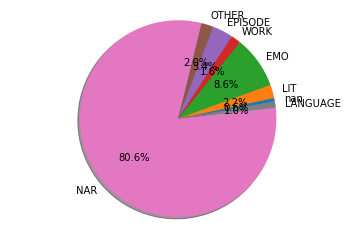

In [20]:
# на примере случайной выборки из датасета
labels = list(set(sample_notes.TAG))
sizes = [Counter(list(sample_notes.TAG))[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [21]:
# задаем "кириллические" символы
cyr = "абвгдеёжзийклмнопрстуфхцчшщъыьэюя " 
cyrillic = cyr + cyr.upper() + punct

def is_russian(text):
    """ определяем, кириллический ли текст """
    all_len = len(text)
    if all_len:
        cyr_len = 0
        for sym in text:
            if sym in cyrillic:
                cyr_len += 1
        if cyr_len/all_len > 0.5:
            if ("ї" not in text) and ("є" not in text) and ("ѣ" not in text):
                return True
    return False


def is_poetry(text):
    """ проверяем, есть ли в тексте длинные стихи """
    lines = text.split("\n")
    poetry_lines = [x for x in lines if x.strip().startswith(">")]
    if len(poetry_lines) > 5:
        return True
    else:
        return False

In [22]:
def clean_table(pandas_table, min_len, max_len):
    """ фильтруем таблицу """
    pandas_table["length"] = pandas_table.notes.apply(lambda x: len(x))
    pandas_table = pandas_table[(pandas_table["length"] < 1500) & (pandas_table["length"] > 500)]
    pandas_table["russian"] = pandas_table["notes"].apply(lambda x: is_russian(x))
    pandas_table = pandas_table[(pandas_table["russian"] == True)]
    pandas_table["poetry"] = pandas_table["notes"].apply(lambda x: is_poetry(x))
    pandas_table = pandas_table[(pandas_table["poetry"] == False)]
    return pandas_table

In [23]:
sample_notes_new = clean_table(sample_notes, 500, 1500)

/home/laidhimonthegreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [31]:
sample_notes_new.TAG = list(["OTHER" if x not in ["EPISODE", "NAR", "WORK", "EMO"] else x for x in list(sample_notes_new.TAG)])

In [32]:
len(sample_notes_new)

288

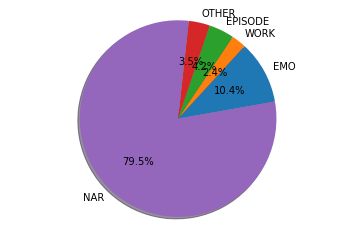

In [33]:
# на примере чуть более сбалансированной выборки
labels = list(set(sample_notes_new.TAG))
sizes = [Counter(list(sample_notes_new.TAG))[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

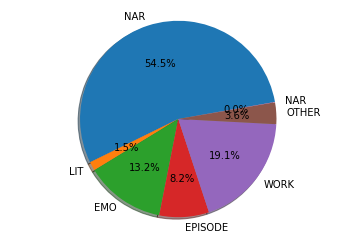

In [14]:
# на примере чуть более сбалансированной выборки
labels = list(set(markup_notes.TAG))
sizes = [Counter(list(markup_notes.TAG))[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [15]:
# добавляем столбец с текстом без стоп-слов  

markup_notes["words"] = markup_notes["notes"].apply(lambda x: normalize(x)) 

### Классификация для маленького корпуса

In [16]:
small_EMO = markup_notes[markup_notes.TAG == "EMO"].sample(150)
small_NAR = markup_notes[markup_notes.TAG == "NAR"].sample(150)
small_EPISODE = markup_notes[markup_notes.TAG == "EPISODE"].sample(150)
small_WORK = markup_notes[markup_notes.TAG == "WORK"].sample(150) 

In [17]:
my_small_dataset = pd.concat([small_EMO, small_NAR, small_EPISODE, small_WORK])

In [18]:
X, y, author = my_small_dataset.notes, my_small_dataset.TAG, my_small_dataset.author
X_train, X_test, y_train, y_test, author_train, author_test = train_test_split(X, y, author, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=10) #BOW + TF-IDF
classifier_tfidf = LogisticRegression(solver='newton-cg', multi_class='multinomial') #мультиклассовая 

In [19]:
clf_tfidf = Pipeline([
    ('vect', tfidf),
    ('clf', classifier_tfidf),
])

# учим классификатор
%time clf_tfidf.fit(X_train, y_train)

CPU times: user 295 ms, sys: 12 ms, total: 307 ms
Wall time: 308 ms


Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=10, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling

In [20]:
predictions_tfidf = clf_tfidf.predict(X_test)

In [21]:
def evaluate(true, predicted):

    # макро-усреднение
    print("Precision: {0:6.2f}".format(precision_score(true, predicted, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(true, predicted, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(true, predicted, average='macro')))

    print("...")
    # микро-усреднение
    print("Precision: {0:6.2f}".format(precision_score(true, predicted, average='micro')))
    print("Recall: {0:6.2f}".format(recall_score(true, predicted, average='micro')))
    print("F1-measure: {0:6.2f}".format(f1_score(true, predicted, average='micro')))

    print("...")
    # accuracy
    print("Accuracy: {0:6.2f}".format(accuracy_score(true, predicted)))

In [22]:
# замеры качества вряд ли можно назвать достоверными на не слишком большой выборке, но попробуем

evaluate(y_test, predictions_tfidf)

Precision:   0.74
Recall:   0.73
F1-measure:   0.73
...
Precision:   0.73
Recall:   0.73
F1-measure:   0.73
...
Accuracy:   0.73


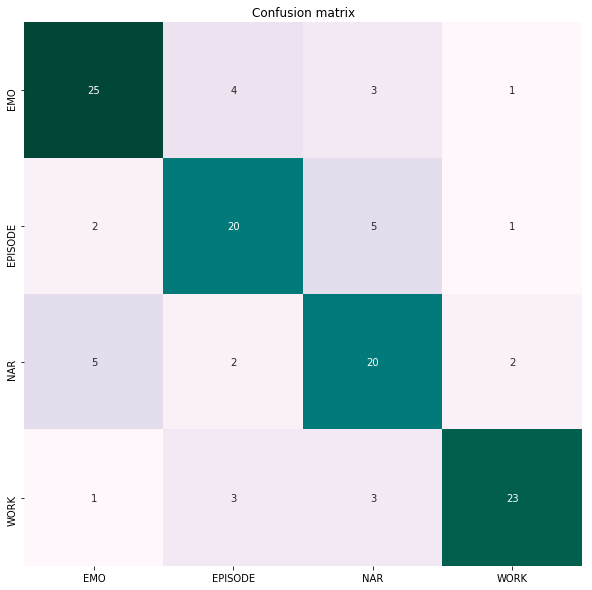

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

m = confusion_matrix(y_test, predictions_tfidf)

labels = clf_tfidf.classes_
plt.figure(figsize = (10,10))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

### Формируем датасет для последующей разметки 

In [24]:
cleaned_big_table = pd.read_csv("big_cleaned_table.csv", sep="\t")

In [25]:
len(cleaned_big_table)

120865

In [26]:
cleaned_preds = clf_tfidf.predict(cleaned_big_table.notes)

In [27]:
# считаем вероятности классов для записей
probs = clf_tfidf.predict_proba(cleaned_big_table.notes)

In [28]:
cleaned_preds[:10]

array(['EPISODE', 'NAR', 'NAR', 'NAR', 'EMO', 'NAR', 'EMO', 'EPISODE',
       'EMO', 'EMO'], dtype=object)

In [29]:
probs[:10]

array([[0.08227986, 0.53671076, 0.28685978, 0.0941496 ],
       [0.11970558, 0.21403293, 0.48690747, 0.17935401],
       [0.20282541, 0.2098432 , 0.33113613, 0.25619526],
       [0.22852852, 0.22364322, 0.28586944, 0.26195881],
       [0.41377638, 0.21885467, 0.19384019, 0.17352876],
       [0.17250171, 0.29783031, 0.37095507, 0.15871292],
       [0.59708079, 0.13058265, 0.17237756, 0.099959  ],
       [0.24628286, 0.32081057, 0.24091902, 0.19198756],
       [0.3797931 , 0.13967787, 0.34828081, 0.13224821],
       [0.38481594, 0.18398837, 0.23454988, 0.19664581]])

In [30]:
cleaned_big_table["EMO_PRED"] = [round(x[0], 3) for x in probs]
cleaned_big_table["EPISODE_PRED"] = [round(x[1], 3) for x in probs]
cleaned_big_table["WORK_PRED"] = [round(x[3], 3) for x in probs]
cleaned_big_table["NAR_PRED"] = [round(x[2], 3) for x in probs]

In [31]:
cleaned_big_table

,Unnamed: 0,notes,dates,id,author,length,russian,poetry,note_id,EMO_PRED,EPISODE_PRED,WORK_PRED,NAR_PRED
0,1,"Ночью мы достигли банки Антон-Дорн, в Датском ...",0/0/0,2268,Олег Владимирович Амитров,731,True,False,1,0.082,0.537,0.094,0.287
1,7,"22, к ночи, дошел до Молодочны, куда прибыл ко...",1609/8/22,1081,Самуил Бельский,558,True,False,7,0.120,0.214,0.179,0.487
2,10,"25, в Минск, где его милость пан Гетман польны...",1609/8/25,1081,Самуил Бельский,782,True,False,10,0.203,0.210,0.256,0.331
3,19,"3, к ночи, прибыли в Коханов. Там его милость ...",1609/9/3,1081,Самуил Бельский,577,True,False,19,0.229,0.224,0.262,0.286
4,20,4 Его Королевское Величество прибыл в Оршу; зд...,1609/9/4,1081,Самуил Бельский,607,True,False,20,0.414,0.219,0.174,0.194
5,25,9 привезены из Вильны девять осадных пушек; че...,1609/9/9,1081,Самуил Бельский,833,True,False,25,0.173,0.298,0.159,0.371
6,37,22 стояли там же; весь день прошел в разрешени...,1609/9/22,1081,Самуил Бельский,1227,True,False,37,0.597,0.131,0.100,0.172
7,38,23 мы подвинулись к Смоленску на 2 1/2 мили. З...,1609/9/23,1081,Самуил Бельский,631,True,False,38,0.246,0.321,0.192,0.241
8,40,"25 мы остановились на том месте, куда прибыл п...",1609/9/25,1081,Самуил Бельский,516,True,False,40,0.380,0.140,0.132,0.348
9,45,"30 к ночи мы были в селении, называемом Есепна...",1609/9/30,1081,Самуил Бельский,585,True,False,45,0.385,0.184,0.197,0.235


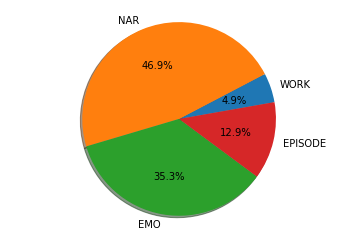

In [32]:
# распределение во всем корпусе (предположительно)
labels = list(set(cleaned_preds))
sizes = [Counter(list(cleaned_preds))[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [33]:
cleaned_big_table["PRED"] = list(cleaned_preds)

In [34]:
# формируем датасет (для того, чтобы получить хотя бы относительно равномерное распределение)

"""
cleaned_big_table[cleaned_big_table.PRED == "EPISODE"].sample(2500).to_csv("./corpus_for_annotators/episode_corpus.csv", sep = "\t")
cleaned_big_table[cleaned_big_table.PRED == "EMO"].sample(2500).to_csv("./corpus_for_annotators/emo_corpus.csv", sep = "\t")
cleaned_big_table[cleaned_big_table.PRED == "NAR"].sample(2500).to_csv("./corpus_for_annotators/nar_corpus.csv", sep = "\t")
"""

'\ncleaned_big_table[cleaned_big_table.PRED == "EPISODE"].sample(2500).to_csv("./corpus_for_annotators/episode_corpus.csv", sep = "\t")\ncleaned_big_table[cleaned_big_table.PRED == "EMO"].sample(2500).to_csv("./corpus_for_annotators/emo_corpus.csv", sep = "\t")\ncleaned_big_table[cleaned_big_table.PRED == "NAR"].sample(2500).to_csv("./corpus_for_annotators/nar_corpus.csv", sep = "\t")\n'

In [35]:
# дневники одного из авторов занимают непропорционально большое количество записей "WORK" - оставим лишь часть из них
nopetr = cleaned_big_table[(cleaned_big_table.PRED == "WORK") & (cleaned_big_table.id != 468)].sample(2200)
petr = cleaned_big_table[(cleaned_big_table.PRED == "WORK") & (cleaned_big_table.id == 468)].sample(300)
work = pd.concat([nopetr, petr])

In [36]:
# формируем датасет для рабочих отчётов
work.to_csv("./corpus_for_annotators/work_corpus.csv", sep = "\t")

In [37]:
episode_c = pd.read_csv("./corpus_for_annotators/episode_corpus.csv", sep = "\t")
work_c = pd.read_csv("./corpus_for_annotators/work_corpus.csv", sep = "\t")
emo_c = pd.read_csv("./corpus_for_annotators/emo_corpus.csv", sep = "\t")
nar_c = pd.read_csv("./corpus_for_annotators/nar_corpus.csv", sep = "\t")

In [38]:
# загружаем общий датасет
base_corpus = pd.concat([episode_c, work_c, emo_c, nar_c])

/home/laidhimonthegreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [39]:
new_corpus = base_corpus.drop(columns = ["Unnamed: 0", "Unnamed: 0.1", "author", "dates", "length",
                               "poetry", "russian"])

In [40]:
new_corpus.head()

,EMO_PRED,EPISODE_PRED,NAR_PRED,PRED,TAG,WORK_PRED,id,note_id,notes
0,0.286,0.411,0.200,EPISODE,EMO,0.103,3,177910,"23.30. Только что из Большого театра, где помп..."
1,0.143,0.382,0.324,EPISODE,EPISODE,0.151,3,178342,Мокро. Дождь-снег. Туман. Утром — в «Сосны». В...
2,0.258,0.317,0.279,EPISODE,EPISODE,0.146,3,170274,"На днях был у Вс. Иванова, Павленко и Н. Тихон..."
3,0.048,0.587,0.129,EPISODE,WORK,0.235,4,227162,"Рано утром, переходя ж[елезную] д[орогу], натк..."
4,0.147,0.362,0.346,EPISODE,WORK,0.144,4,219717,Всю ночь проходил под дождем. Только утром при...


In [41]:
new_corpus = new_corpus[["note_id", "notes", "id", "PRED"]]

In [42]:
new_corpus = new_corpus.sample(10000)

In [43]:
# формируем подкорпусы для разметчиков

corpus_part_1 = new_corpus[:1000]
corpus_part_2 = new_corpus[1000:2000]
corpus_part_3 = new_corpus[2000:3000]
corpus_part_4 = new_corpus[3000:4000]
corpus_part_5 = new_corpus[4000:5000]
corpus_part_6 = new_corpus[5000:6000]
corpus_part_7 = new_corpus[6000:7000]
corpus_part_8 = new_corpus[7000:8000]
corpus_part_9 = new_corpus[8000:9000]
corpus_part_10 = new_corpus[9000:10000]

In [44]:
for i, x in enumerate([corpus_part_1, corpus_part_2, corpus_part_3, corpus_part_4, corpus_part_5,
          corpus_part_6, corpus_part_7, corpus_part_8, corpus_part_9, corpus_part_10]):
    x.to_excel("./corpus_for_annotators/sliced_corpora_new/corpus_part_{}.xlsx".format(i+1))

### Ключевые слова для каждой из основных категорий.

In [45]:
X, y, author = markup_notes.notes, markup_notes.TAG, markup_notes.author
X_train, X_test, y_train, y_test, author_train, author_test = train_test_split(X, y, author, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=10) #BOW + TF-IDF
classifier_tfidf = LogisticRegression(solver='newton-cg', multi_class='multinomial') #мультиклассовая 

In [46]:
emo_corpus = get_corpus_by_tag(markup_notes, "EMO")
work_corpus = get_corpus_by_tag(markup_notes, "WORK")
nar_corpus = get_corpus_by_tag(markup_notes, "NAR")
episode_corpus = get_corpus_by_tag(markup_notes, "EPISODE")

In [47]:
tfidf_for_corpuses = TfidfVectorizer(ngram_range=(1,1), min_df=1)
X_corpus = tfidf_for_corpuses.fit_transform([emo_corpus, work_corpus, nar_corpus, episode_corpus])

id2word = {i:word for i,word in enumerate(tfidf_for_corpuses.get_feature_names())}
texts_vectors_corpus = tfidf_for_corpuses.transform([emo_corpus, work_corpus, nar_corpus, episode_corpus])
keywords_corpus = [[id2word[w] for w in top] for top in texts_vectors_corpus.toarray().argsort()[:,:-30:-1]] 

In [48]:
keywords_corpus

[['это',
  'то',
  'грустно',
  'очень',
  'сегодня',
  'id',
  'com',
  'жизни',
  'время',
  'знаю',
  'что',
  'хочу',
  'жизнь',
  'хочется',
  'кажется',
  'могу',
  'день',
  'люблю',
  'всё',
  'любви',
  'хотя',
  'боюсь',
  'чувствую',
  'человек',
  'буду',
  'вчера',
  'думаю',
  'жить',
  'лет'],
 ['квт',
  'ссср',
  'гэс',
  'тыс',
  'энергетики',
  'министерства',
  'строительства',
  'работ',
  'состоялось',
  'мощностей',
  'минэнерго',
  'грэс',
  'строительство',
  'оборудования',
  'госплана',
  'коллегии',
  'кпсс',
  'цк',
  'плотины',
  '1960',
  'работы',
  'плана',
  'млн',
  'коллегия',
  'хозяйства',
  'это',
  'совещание',
  'развития',
  'ввода'],
 ['это',
  'сегодня',
  'очень',
  'com',
  'id',
  'день',
  'то',
  'вечером',
  'утром',
  'вчера',
  'время',
  'домой',
  'часов',
  'дома',
  '10',
  'доклад',
  'нам',
  'сказал',
  'весь',
  'дня',
  'письмо',
  'читал',
  'го',
  'около',
  'по',
  'получил',
  'часа',
  'человек',
  'который'],
 ['то',
  

### Классификация текстов.

In [49]:
# весь корпус
big_table = pd.read_csv("big_big_table.csv", sep = "\t")
len(big_table)

121431

In [77]:
big_preds = clf_tfidf.predict(big_table.notes)

### Попробуем обобщить на разных подкорпусах.

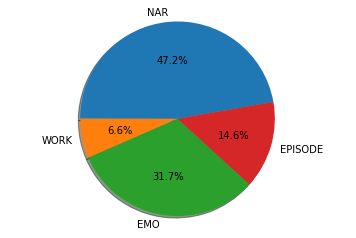

In [78]:
# распределение во всем корпусе (предположительно)
labels = list(set(big_preds))
sizes = [Counter(list(big_preds))[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [79]:
big_table["TAG"] = big_preds

In [80]:
galina_table = big_table[big_table.author == "Галина Г. Ларская"]

In [81]:
galina_preds = clf_tfidf.predict(galina_table.notes)

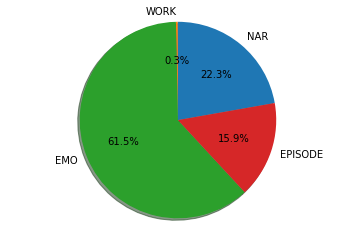

In [82]:
# распределение в текстах Галины Ларской (предположительно)
labels = list(set(galina_preds))
sizes = [Counter(list(galina_preds))[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [83]:
mil_table = big_table[big_table.author == "Дмитрий Алексеевич Милютин"]

In [84]:
mil_preds = clf_tfidf.predict(mil_table.notes)

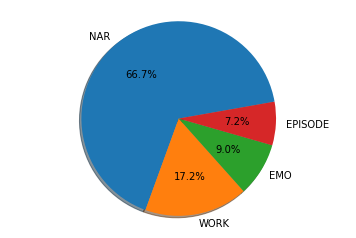

In [85]:
# распределение в текстах Милютина (предположительно)
labels = list(set(mil_preds))
sizes = [Counter(list(mil_preds))[x] for x in labels] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()